In [1]:
from foundry.util.runtime import setup
setup()
import jax
print("Devices:", jax.devices())

from image_diffusion.main import logger
logger.setLevel('INFO')

Devices: [CudaDevice(id=0), CudaDevice(id=1)]


In [2]:
import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train
from foundry.core.dataclasses import dataclass

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console

import matplotlib.pyplot as plt
from typing import Sequence

In [3]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

In [4]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion/mnist-ddpm:v14")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

In [5]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

[17:25:02] INFO     image_diffusion - Learning T-SNE embedding...
[17:25:59] INFO     image_diffusion - Fit T-SNE embedding


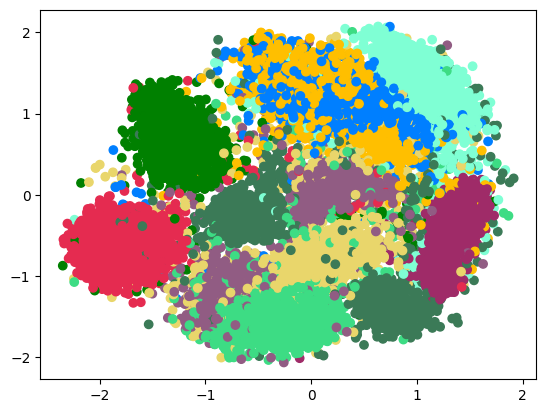

In [6]:
if checkpoint.config.condition_type == "tsne":
    latents = test_data.cond
    encode = lambda x: x
    decode = lambda x: x
else:
    from latent_embed import train_embedding
    latents, encode, decode = train_embedding(
        test_data.cond, mode="tsne", 
        iterations=10_000
    )
embed_scatter(latents, test_data.label)

In [7]:
if checkpoint.config.condition_type == "image":
    from foundry.train.reporting import Image

    X, Y = npx.meshgrid(
        npx.linspace(-3, 3, 32),
        npx.linspace(-3, 3, 32)[::-1],
    )
    Z = npx.stack((X,Y), axis=-1)
    # (row, col, height, width, channel)
    images = F.vmap(F.vmap(decode))(Z)
    # (row, height, col, width, channel)
    images = npx.permute_dims(images, (0, 2, 1, 3, 4))
    Image(images.reshape((images.shape[0]*images.shape[1], images.shape[2]*images.shape[3], 1)))

In [8]:
import foundry.diffusion.nonparametric as nonparametric
import functools

keypoints = train_data.cond[:32]

@dataclass
class EvalSample:
    cond: jax.Array
    x_noised: jax.Array
    t: jax.Array
    out_model: jax.Array
    out_nw: jax.Array
    out_keypoints: jax.Array
    err: jax.Array

@F.jit
def eval(vars, rng_key):
    cond = jax.random.uniform(rng_key, (2,), minval=-3, maxval=3)
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t, cond=cond)
    sample = lambda rng: schedule.sample(rng, denoiser, npx.zeros(test_data.data[0].shape))

    samples_rng, ref_rng = foundry.random.split(rng_key)
    ref_sample = sample(ref_rng)
    # sample 16 times from the trained model at this conditioning location
    samples = jax.vmap(sample)(foundry.random.split(samples_rng, 16))
    # noise the reference sample to some level
    # t = jax.random.randint(rng_key, (), 1, schedule.num_steps)
    t = npx.array(schedule.num_steps // 2)
    x_noised, _, _ = schedule.add_noise(rng_key, ref_sample, t)
    out_nw = schedule.output_from_denoised(
        x_noised, t,
        schedule.compute_denoised(
            x_noised, t, samples
    ))
    out_model = model.apply(vars, x_noised, t, cond=cond)
    # apply the model, conditioned at the keypoints
    out_keypoints = jax.lax.map(
        lambda k: model.apply(vars, x_noised, t, cond=k), 
        keypoints
    )
    # x_model = schedule.denoised_from_output(
    #     x_noised, t,
    #     model.apply(vars, x_noised, t, cond=cond)
    # )
    err = npx.mean(npx.square(out_model - out_nw))
    return EvalSample(
        cond=cond,
        x_noised=x_noised, t=t,
        out_model=out_model, out_nw=out_nw,
        out_keypoints=out_keypoints,
        err=err
    )

eval_batch = functools.partial(
    F.vmap(eval, in_axes=(None, 0)),
    vars
)

eval_samples = []
logger.info("Evaluating error at samples")
r = foundry.random.PRNGSequence(42)
for i in rich.progress.track(range(32)):
    batch = eval_batch(
        foundry.random.split(next(r),32),
    )
    eval_samples.append(batch)
eval_samples : EvalSample = tree.map(lambda *x: npx.concatenate(x, 0), *eval_samples)

[17:26:03] INFO     image_diffusion - Evaluating error at samples


2024-11-19 17:26:12.030368: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-19 17:26:12.031159: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-19 17:26:13.307184: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-19 17:26:13.473592: W external/xla/xla/tsl/framework/bfc_allocato

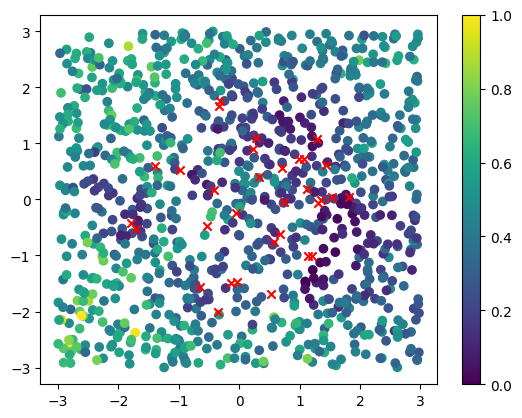

In [9]:
plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=npx.clip(eval_samples.err, 0, 1))
# plot the keypoints
plt.scatter(keypoints[:,0], keypoints[:,1], c="red", marker="x")
plt.colorbar()

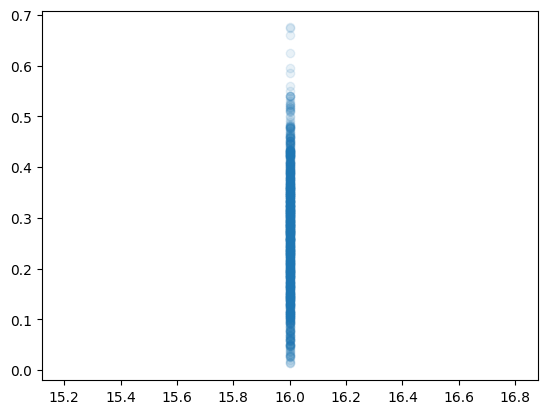

In [10]:
plt.scatter(eval_samples.t, eval_samples.err.clip(0,10), alpha=0.1)

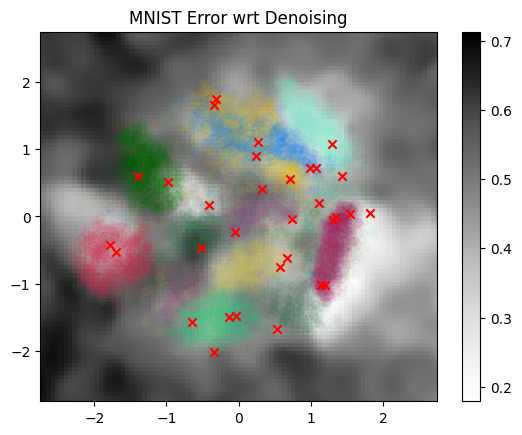

In [11]:
def graph_smoothed(conds, errs):
    xi = npx.linspace(-3,  3, 100)
    yi = npx.linspace(-3, 3, 100)
    def smooth(x, y):
        z = npx.stack((x,y), axis=-1)
        log_weights = -20*npx.sum(npx.square(z - conds), axis=-1)
        log_norm = jax.scipy.special.logsumexp(log_weights)
        log_weights = log_weights - log_norm
        weights = npx.exp(log_weights)
        err = npx.clip(errs, 0, 1)
        return npx.sum(weights * err)
    zi = jax.vmap(jax.vmap(smooth))(*npx.meshgrid(xi, yi))
    plt.pcolormesh(xi, yi, zi, cmap="Greys")
    plt.ylim(-2.75, 2.75)
    plt.xlim(-2.75, 2.75)
    plt.colorbar()

graph_smoothed(eval_samples.cond, npx.sqrt(eval_samples.err).clip(0,1))
plt.title("MNIST Error wrt Denoising")
embed_scatter(latents, test_data.label, alpha=0.03)
plt.scatter(keypoints[:,0], keypoints[:,1], c="red", marker="x")

In [12]:
import foundry.train
import foundry.train.console
from foundry.train import LossOutput
from foundry.data import PyTreeData

import flax.linen as nn

class KeypointModel(nn.Module):
    @nn.compact
    def __call__(self, cond, t):
        input = npx.concatenate([t[None], cond])
        logits = nn.Sequential([
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(64),
            nn.gelu,
            nn.Dense(keypoints.shape[0]),
        ])(input)
        return jax.nn.softmax(logits, axis=-1)

keypoint_model = KeypointModel()
keypoint_vars = keypoint_model.init(next(r), 
    npx.zeros((2,)), npx.zeros((), dtype=npx.int32)
)
iterations = 10_000
optimizer = optax.adamw(optax.cosine_decay_schedule(4e-3, iterations))
opt_state = optimizer.init(keypoint_vars["params"])

@foundry.train.batch_loss
def loss_fn(keypoint_vars, rng_key, sample : EvalSample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = tree.map(lambda k: npx.sum(alphas*k, axis=0), sample.out_keypoints)
    err = npx.sum(npx.square(interpolated - sample.out_model))
    return LossOutput(
        loss=err,
        metrics={"error": err}
    )

with foundry.train.loop(
    PyTreeData(eval_samples).stream().shuffle(foundry.random.key(42)).batch(16),
    iterations=iterations,
    rng_key=foundry.random.key(42)
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, keypoint_vars, metrics = foundry.train.step(
                loss_fn, optimizer, opt_state=opt_state,
                vars=keypoint_vars, rng_key=step.rng_key,
                batch=step.batch
            )
            if step.iteration % 100 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )
logger.info("Evaluating samples")
def eval(sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = tree.map(lambda k: npx.sum(alphas*k, axis=0), sample.out_keypoints)
    err = npx.sum(npx.square(interpolated - sample.out_model))
    return err
keypoint_errs = jax.lax.map(eval, eval_samples, batch_size=1024)

Iteration       ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━  4416/10000  44% 0:00:28 0:00:24
Epoch           ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━  69/156      44% 0:00:30 0:00:24
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/64         0% 0:00:01 0:00:00


[17:28:22] INFO     foundry.train -      0 | error: 633355.0625
[17:28:23] INFO     foundry.train -    100 | error: 2021.171875
[17:28:24] INFO     foundry.train -    200 | error: 188.78958129882812
[17:28:25] INFO     foundry.train -    300 | error: 98.40922546386719
           INFO     foundry.train -    400 | error: 97.93940734863281
[17:28:26] INFO     foundry.train -    500 | error: 88.40499877929688
           INFO     foundry.train -    600 | error: 85.49381256103516
[17:28:27] INFO     foundry.train -    700 | error: 90.98856353759766
[17:28:28] INFO     foundry.train -    800 | error: 61.73124694824219
           INFO     foundry.train -    900 | error: 66.75487518310547
           INFO     foundry.train -   1000 | error: 102.89088439941406
[17:28:29] INFO     foundry.train -   1100 | error: 101.7154541015625
           INFO     foundry.train -   1200 | error: 96.69638061523438
[17:28:30] INFO     foundry.train -   1300 | error: 66.3508071899414
           INFO     foundry.tra

[17:28:46] INFO     foundry.train -   4500 | error: 80.65902709960938
[17:28:47] INFO     foundry.train -   4600 | error: 83.6668930053711
           INFO     foundry.train -   4700 | error: 56.22125244140625
[17:28:48] INFO     foundry.train -   4800 | error: 60.62974166870117
           INFO     foundry.train -   4900 | error: 81.3787841796875
[17:28:49] INFO     foundry.train -   5000 | error: 92.75518035888672
           INFO     foundry.train -   5100 | error: 64.44932556152344
[17:28:50] INFO     foundry.train -   5200 | error: 83.251220703125
           INFO     foundry.train -   5300 | error: 88.93859100341797
[17:28:51] INFO     foundry.train -   5400 | error: 70.65960693359375
           INFO     foundry.train -   5500 | error: 83.86986541748047
[17:28:52] INFO     foundry.train -   5600 | error: 71.7535171508789
[17:28:53] INFO     foundry.train -   5700 | error: 73.83141326904297
           INFO     foundry.train -   5800 | error: 61.403175354003906
[17:28:54] INFO     foun

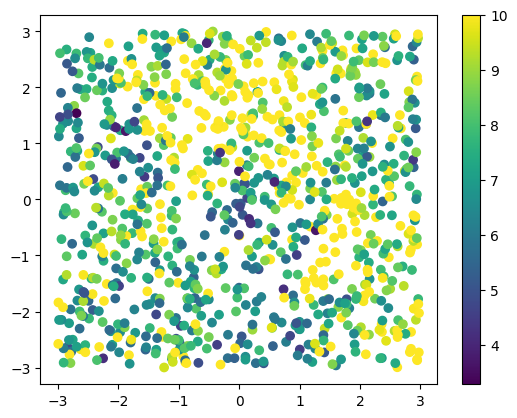

In [13]:
plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=npx.sqrt(keypoint_errs).clip(0,10))
plt.colorbar()

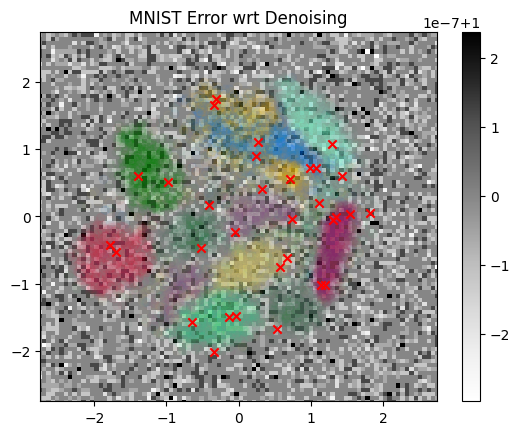

In [16]:
graph_smoothed(eval_samples.cond, npx.sqrt(keypoint_errs).clip(0,10))
plt.title("MNIST Error wrt Denoising")
embed_scatter(latents, test_data.label, alpha=0.03)
plt.scatter(keypoints[:,0], keypoints[:,1], c="red", marker="x")